In [1]:
!git clone https://github.com/MarkBridge11/RINE-extended

Cloning into 'RINE-extended'...
remote: Enumerating objects: 488, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 488 (delta 12), reused 2 (delta 0), pack-reused 461 (from 2)
Receiving objects: 100% (488/488), 100.69 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (307/307), done.


In [2]:
import sys
sys.path.append('/content/RINE-extended')

In [3]:
!pip install scikit-image imageio opencv-python kornia git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-q5pa1fu4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-q5pa1fu4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=db550fab1d662af889619791a046536ab3b7e1c468b7f1c02804b28becefb36d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvvrh6gx/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import sys
import os
from src.utils import get_transforms, get_our_trained_model, get_model, get_transforms_multiclass
from src.data_multiclass import mask_aware_crop
from PIL import Image
import torch
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#_, transforms, _ = get_transforms()
#model = get_our_trained_model(ncls="ldm", device=device)
#model.to(device).eval();

100%|███████████████████████████████████████| 890M/890M [00:37<00:00, 24.8MiB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transforms_train, _ , transforms_test = get_transforms_multiclass()
ckpt_path = "/content/RINE-extended/ckpt/RINE_multiclass_SIDA_dataset.pth"
model = get_our_trained_model(device=device,ckpt_path=ckpt_path)
model.to(device).eval();

In [ ]:
real_path = "/content/RINE-extended/demo/aadlygmazf.jpg"
real_image = Image.open(real_path).convert("RGB")
real_image_mask = None
real_image, real_image_mask = mask_aware_crop(real_image, real_image_mask) # inserted here mask aware crop
real_tensor = transforms_test(real_image).unsqueeze(0).to(device)
real_logit , _ = model(real_tensor)
#real_probability = torch.sigmoid(real_logit)

real_probabilities = F.softmax(real_logit, dim=1)

# print(
#     f"real image - prob. to be fake: {real_probability.detach().cpu().numpy()[0][0]*100:1.1f}%"
# )

real image - prob. to be fake: 35.6%


In [ ]:
# Move to numpy for inspection
real_probabilities = real_probabilities.detach().cpu().numpy()[0]

# Print nicely
for cls_id, prob in enumerate(real_probabilities):
    print(f"class {cls_id}: {prob*100:.1f}%")

# To have the predicte class
pred_class = real_probabilities.argmax()
print(f"Predicted class: {pred_class}")

# STILL TO MODIFY THINGS BELOW HERE FOR MULTICLASS!

In [7]:
def get_token_importance(model, x): # should return the feature, per each transformer block, weighted by TIE

    g = torch.stack([h.output for h in model.hooks], dim=2)[0, :, :, :]  # [tokens, batch, blocks, dim], with [0, :, :, :] I take only the CLS, [1:, :, :, :] I tkae the others

    print(f"Shape of g:{g.shape}") # to confirm if i'm taking only the cls or not

    g = model.proj1(g.float()) # remains of the same size

    # apply alpha weights
    weights = F.softmax(model.alpha, dim=1)[0]
    contrib = g * weights
    return contrib.cpu().detach().numpy()

In [8]:
def map_to_image(block_map, image_size):
    heatmap = cv2.resize(block_map, image_size, interpolation=cv2.INTER_CUBIC)
    # normalize 0–1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    return heatmap

In [9]:
def overlay_heatmap(img, heatmap, alpha=0.5):
    cmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cmap = cv2.cvtColor(cmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.array(img), 1 - alpha, cmap, alpha, 0)
    return overlay

In [16]:
contrib = get_token_importance(model, real_tensor)
contrib_map = np.linalg.norm(contrib, axis=-1) # this will collapse the embedding dim having only a matrix/vector for the contribution
#grid_size = int(np.sqrt(contrib_map.shape[0])) # useful only if considering all the other tokens and not only CLS
print(contrib_map.shape)

Shape of g:torch.Size([1, 24, 1024])
(1, 24)


In [11]:
# ONLY WHEN I TAKE ALL THE TOKENS
# #block_maps = contrib_map.reshape(grid_size, grid_size, -1) # <- same syntax of below
# block_maps = []
# for b in range(contrib_map.shape[1]):
#     block_map = contrib_map[:, b].reshape(grid_size, grid_size)
#     block_maps.append(block_map)
# block_maps = np.stack(block_maps)  # [blocks, grid, grid]

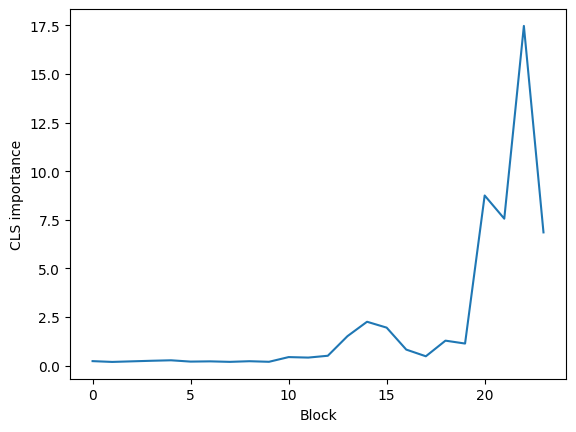

In [23]:
plt.plot(range(contrib_map.shape[1]),contrib_map.squeeze())
plt.xlabel("Block")
plt.ylabel("CLS importance")
plt.show()

In [13]:
heatmap = map_to_image(block_maps[:,:,0], real_image.size)
overlay = overlay_heatmap(real_image, heatmap, alpha=0.5)

plt.imshow(overlay)
plt.axis("off")
plt.show()

NameError: name 'block_maps' is not defined

In [ ]:
# fake_path = "/content/RINE-extended/demo/zzrybysskm.jpg"
# fake_image = Image.open(fake_path).convert("RGB")
# fake_tensor = transforms(fake_image).unsqueeze(0).to(device)
# fake_logit = model(fake_tensor)[0]
# fake_probability = torch.sigmoid(fake_logit)
# print(
#     f"fake image - prob. to be fake: {fake_probability.detach().cpu().numpy()[0][0]*100:1.1f}%"
# )
